# importering af libraries

In [2]:
# torch libraries (til neural network):
import torch 
import torch.nn as nn 
from torch import nn,optim # optimizers
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader # laver data til batches
from torchsummary import summary # laver summary af neural network

# matplotlib libraries (til at lave plots):
import matplotlib.pyplot as plt # laver plots
import matplotlib.gridspec as gridspec # laver grid af plots

# andre libraries:
import os # interagere med operativsystemet
import random #  generere tilfældige tal
import shutil #  kopierer filer
import numpy as np 

# Opsætter din GPU eller CPU

In [131]:
# For Windows (cuda):

# # Tjekker om din gpu er tilgængelig og bruger den. Hvis ikke bruger den cpu
# if torch.cuda.is_available(): 
#     device = torch.device('cuda')
#     print("Using gpu")
# else: 
#     device = torch.device('cpu')
#     print("Using cpu")

In [38]:
# For mac (M-chip):

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available. Using CPU.")

MPS backend is available. Using GPU.


# Sortering af data

In [174]:
# Den her kode er taget fra projektet "Chest X-Ray Images (Pneumonia)" af PAUL MOONEY

# Det koden gør er at omstrukturere dataen så det indeholder 80% af træningssættet, 10% af valideringssættet  og 10% af testssættet.
# Udover det omfordeler den dataen således at der i alle mapper er samme fordeling mellem normal og pneumonia billeder.
# Fordelingen bliver cirka 27% normal og 73% pneumonia.
# Validation sættet indeholder kun 16 billeder, hvilket vi tror er for lidt til at vi kan bruge. Så vi bruger denne omfordeling
# til at skabe noget mere struktur i vores data.

#_________________________________________________________________________________________________________________________________________

dataset_path = '/Users/valdemarstamm/Desktop/DTU/1. Semester/3 ugers - ITIS projekt/Data/chest_xray'
new_dataset_path = '/Users/valdemarstamm/Desktop/DTU/1. Semester/3 ugers - ITIS projekt/Data/New sorted'

if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f'{dataset_path}/{split}/{cls}'
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        random.shuffle(all_files)

        train_files = all_files[:int(len(all_files) * 0.8)]
        val_files = all_files[int(len(all_files) * 0.8):int(len(all_files) * 0.9)]
        test_files = all_files[int(len(all_files) * 0.9):]

        for file, source_folder in train_files:
            dest = f'{new_dataset_path}/train/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        for file, source_folder in val_files:
            dest = f'{new_dataset_path}/val/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        for file, source_folder in test_files:
            dest = f'{new_dataset_path}/test/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)
#_________________________________________________________________________________________________________________________________________

# Image loading

In [175]:
root_folder = "/Users/valdemarstamm/Desktop/DTU/1. Semester/3 ugers - ITIS projekt/Data/New sorted" 

# Definer transformationer (fx resizing og normalisering)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ændr størrelse på billederne
    transforms.ToTensor(),         # Konverterer billedet til en tensor og skalerer pixelværdierne fra det oprindelige interval [0, 255] til [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standardiser dataen
])

# [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] det er standardværdien for 
# ImageNet datasettet, som vi bruger til at normalisere vores data.

# ImageFolder opretter automatisk labels baseret på undermappernes navne:
# normal → Label 0.
# pneumonia → Label 1.

# DataLoader opdeler dataset i batches og gør det nemt at iterere over billederne under træning.

# Indlæs datasets med ImageFolder
# får billederne som Tensors 
train_dataset = datasets.ImageFolder(root=f"{root_folder}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{root_folder}/test", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{root_folder}/val", transform=transform)

# Opret dataloaders:
# specifikke batch sizes har vi taget inspiration fra "Pneumonia Detection using VGG16 Transfer Learning"
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# definerer labels til senere brug
labels = ['NORMAL', 'PNEUMONIA']

# Opskrivning model

In [176]:
# forklaring af variabler i lagene:
"""
in_channels=x,  # Antallet af input-kanaler (første lag er 3 fordi vi har RGB-billeder).
out_channels=x,  # Antallet af output-kanaler
kernel_size=3,  # Størrelsen af filtrene. Taget fra førnævnte projekt
stride=1,  # Hvor meget filteret flytter sig for hvert trin. Standard værdien er 1
padding=1  # Vi tilføjer 1 pixel rundt om billedet for at undgå, at det bliver for småt
"""

CNN_model = nn.Sequential(
    # Lag 1
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112

    # Lag 2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56

    # Lag 3
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56 -> 28x28

    # Fuldt forbundne lag
    nn.Flatten(),               # Flatten laver alt dataen fra flere dimensioner til en dimension
    nn.Linear(128*28*28, 256),  # Justeret til outputdimensionen fra Flatten
    nn.ReLU(inplace=True),           
    nn.Dropout(0.5),            # Dropout slukker tilfældige neuroner for at forhindre overfitting
                                # i testing er dropout ikke med da alle neuroner skal vægtes ligeligt for ikke at miste data
                                # Standardværdien af dropout er 0.5
    nn.Linear(256, 2)
).to(device)

summary(CNN_model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           25,690,368
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           514
Total params: 25,784,130
Trainable params: 25,784,130
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           25,690,368
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           514
Total params: 25,784,130
Trainable params: 25,784,130
Non-trainable params: 0

# Træning og validation af model

In [137]:
# Vi har valgt at bruge CrossEntropyLoss som vores loss funktion, 
# da det er en standard loss funktion til klassifikation.
# Plus vi har taget inspiration fra CNN-Example.py som vi gennemgik i timen, hvilket også begrunder
# vores valg af optimizer nemlig Adam (Adaptive Moment Estimation)

loss_function = nn.CrossEntropyLoss() # formel der udregner loss funktionen
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)
num_epochs = 10 # antal gange vi vil træne modellen

# Koden har vi skrevet ud fra kommandoerne i nn.module dokumentationen åbnet i python, samt 
# inspiration fra de python filer vi har gennemgået til forlæsningerne. 

train_losses = [] # tom liste til plots
val_losses = [] # tom liste til plots

# Kører igennem hver epoch:
for epoch in range(num_epochs):
    # Bruger CNN_model.train() til at sætte modellen i træningstilstand. Dette gøres fordi
    # fordi visse lag og operationer i neurale netværk opfører sig forskelligt under træning og evaluering.
    train_loss, correct, total = 0, 0, 0  # Nulstiler variablerne: train_loss, correct og total
    
    # Påbegynder træning:
    CNN_model.train()
    train_loss = 0 # loss funktionen for en epoch
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # flytter dataen til devicen (gpu)
        optimizer.zero_grad() # nulstiller gradienten
        outputs = CNN_model(images) # sender igennem modellen
        loss = loss_function(outputs, labels) # udregner loss
        
        # begynder og udfører backpropagation:
        loss.backward() 
        optimizer.step() # opdaterer parametre (vægte og bias)
        train_loss += loss.item() # loss.item() appender det enkelte loss til samlet loss for epochen

        # finder parametre til udregning af accuracy:
        _, predicted = torch.max(outputs, 1) # bruger _ fordi vi ikke bruger variablen til noget
        # torch.max(outputs, 1) finder det output (normal eller pneumonia) med højest værdi 
        # dvs. det output der er mest sandsynligt
        correct += (predicted == labels).sum().item() # her tjekker vi så om forudsigelsen er korrekt og appender
        total += labels.size(0) # appender til total

    # Beregn træningsnøjagtigheden
    training_accuracy = 100 * correct / total

    # Påbegynder validation processen:
    CNN_model.eval() # dette gør bl.a. at dropout operationer ikke udføres
    val_loss, correct, total = 0, 0, 0
    
    with torch.no_grad(): # betyder at der ikke sker backpropagation i denne del
        # dvs gradienterne bliver ikke opdateret i følgende kodeblok:
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = CNN_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # finder parametre til udregning af validation:
            _, predicted = torch.max(outputs, 1) 
            correct += (predicted == labels).sum().item() 
            total += labels.size(0) 
        
        # Beregn valideringsnøjagtigheden
        validation_accuracy = 100 * correct / total

    val_losses.append(val_loss/len(val_loader)) # appender til listen
    train_losses.append(train_loss/len(train_loader)) # appender til listen

    # printer resultaterne for hver epoch (både træning og validering):
    print("--------------------------------------------------")
    print(f"Epoch {epoch+1}/{num_epochs} \n")
    print(f"Training Loss: {train_loss/len(train_loader):.4f} \n") # hvor god den er på træningsdataen
    print(f"Training Accuracy: {training_accuracy:.2f}% \n") # hvor god den er på valideringsdataen
    print(f"Validation Loss: {val_loss/len(val_loader):.4f} \n") # hvor god den gennemsnitligt er på valideringsdataen 
    print(f"Validation Accuracy: {validation_accuracy:.2f}%") # hvor god den er på valideringsdataen
    

--------------------------------------------------
Epoch 1/10 

Training Loss: 0.3749 

Training Accuracy: 85.08% 

Validation Loss: 0.1707 

Validation Accuracy: 94.19%
--------------------------------------------------
Epoch 2/10 

Training Loss: 0.1716 

Training Accuracy: 93.64% 

Validation Loss: 0.1468 

Validation Accuracy: 94.53%
--------------------------------------------------
Epoch 3/10 

Training Loss: 0.1487 

Training Accuracy: 94.34% 

Validation Loss: 0.1180 

Validation Accuracy: 95.56%
--------------------------------------------------
Epoch 4/10 

Training Loss: 0.1302 

Training Accuracy: 95.75% 

Validation Loss: 0.1178 

Validation Accuracy: 96.24%
--------------------------------------------------
Epoch 5/10 

Training Loss: 0.1133 

Training Accuracy: 95.64% 

Validation Loss: 0.1344 

Validation Accuracy: 96.07%
--------------------------------------------------
Epoch 6/10 

Training Loss: 0.1045 

Training Accuracy: 96.22% 

Validation Loss: 0.1217 

Validati

# Testing af modellen

In [138]:
# Nu påbegyndes den endelige testing:
# Samme kode som i valideringen:

# lister til plots:
# Opsamler værdier til at udregne confusion matrix:
predicted_values = [] 
actual_values = [] 

CNN_model.eval()
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = CNN_model(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # appender værdier til listerne til confusion matrix:
        actual_values.append(labels)
        predicted_values.append(predicted)

test_accuracy = 100 * correct / total

# printer resultat for testen:
print("--------------------------------------------------")
print(f"Test Loss: {test_loss/len(test_loader):.4f} \n")
print(f"Test Acc: {test_accuracy:.2f}%")
print("--------------------------------------------------")

--------------------------------------------------
Test Loss: 0.1505 

Test Acc: 96.08%
--------------------------------------------------


# Gem model

In [61]:
# Her kan man gemme modellen når man er færdig med at træne:

# torch.save(CNN_model.state_dict(), 'model.pt')
# ikke kør denne igen ellers overwrites 

# Indlæs model

In [210]:
# Her kan modellen indlæses igen:

CNN_Model_Load = CNN_model.load_state_dict(torch.load('/Users/valdemarstamm/Desktop/DTU/1. Semester/3 ugers - ITIS projekt/73:27 model/model.pt'))

/var/folders/4n/c4xb7yb55lq4vkbt3n8qlq6r0000gn/T/ipykernel_42326/106985473.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_Model_Load = CNN_model.load_state_dict(tor

In [211]:
# Nu påbegyndes den endelige testing:
# Samme kode som i valideringen:

# lister til plots:
# Opsamler værdier til at udregne confusion matrix:
predicted_values = [] # ex på data: [1,0,0,1,0] modellens gæt
actual_values = [] # ex på data: [0,1,0,1,0] sande værdier

loss_function = nn.CrossEntropyLoss() # definere loss_function igen så vi kan gøre det uden at skulle træne modellen igen

CNN_model.eval()  # Sæt den i evalueringsmodus
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = CNN_model(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # appender værdier til listerne til confusion matrix:
        actual_values.append(labels)
        predicted_values.append(predicted)

test_accuracy = 100 * correct / total

# printer resultat for testen:
print("--------------------------------------------------")
print(f"Test Loss: {test_loss/len(test_loader):.4f} \n")
print(f"Test Acc: {test_accuracy:.2f}%")
print("--------------------------------------------------")

--------------------------------------------------
Test Loss: 0.1505 

Test Acc: 96.08%
--------------------------------------------------


# Modeller og plots

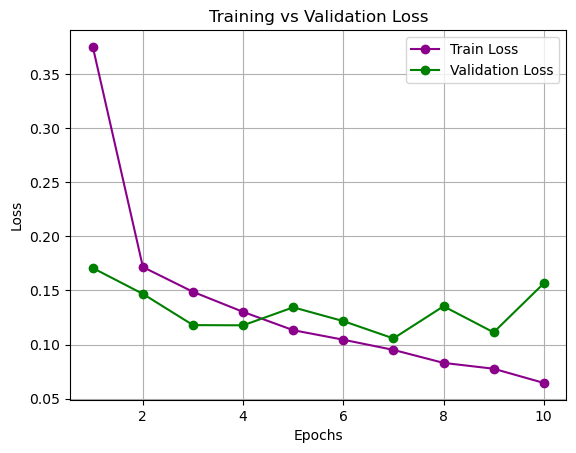

In [217]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='darkmagenta')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

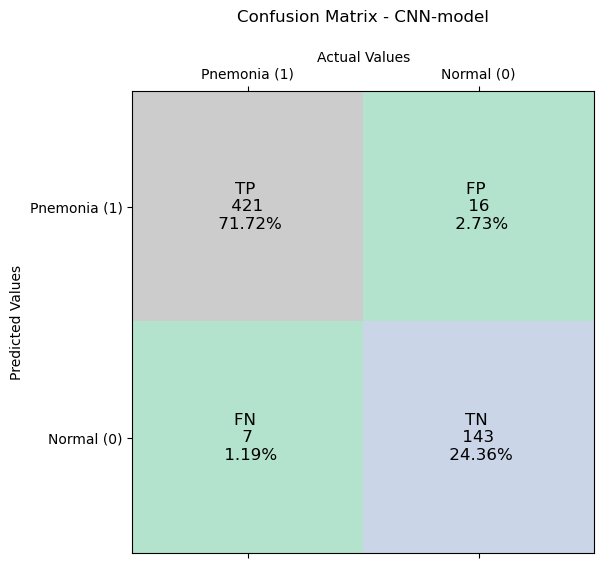

In [ ]:
# Confusion Matrix:

# Her er koden vi har brugt til at lave 3 forskellige plots, 
# i de to matrixer lavet ud fra lægerne, bruges følgende data istedet for:

# Læge 1:
# True_Positive = 40
# False_Positive = 0
# True_Negative = 33
# False_Negative = 27
# total = 100

# Læge 2:
# True_Positive = 53
# False_Positive = 11
# True_Negative = 17
# False_Negative = 19
# total = 100


# her er dataen udtrukket fra vores model:
# vi har en liste med arrays opdelt i batches, som vi først vil lave til et stort array:
# forloopet sker fordi vi skal flytte dataen fra gpu til cpu, for at kunne bruge numpy:
actual_values_np = np.concatenate([tensor.cpu().numpy() for tensor in actual_values], axis=0)
predicted_values_np = np.concatenate([tensor.cpu().numpy() for tensor in predicted_values], axis=0)

# laver arrayet til lister, fordi det er lettere at arbejde med ;)
actual_values_list = actual_values_np.tolist()
predicted_values_list = predicted_values_np.tolist()

# Nu tæller vi de forskellige værdier fra listerne til matrixen:
True_Positive = 0
False_Positive = 0
True_Negative = 0
False_Negative = 0

for i in range(len(actual_values_list)):
    if actual_values_list[i] == 1 and predicted_values_list[i] == 1:
        True_Positive += 1
    elif actual_values_list[i] == 0 and predicted_values_list[i] == 1:
        False_Positive += 1
    elif actual_values_list[i] == 0 and predicted_values_list[i] == 0:
        True_Negative += 1
    elif actual_values_list[i] == 1 and predicted_values_list[i] == 0:
        False_Negative += 1

# procentdel: 
total = len(actual_values_list) # de to lister er lige lange
True_Positive_Percent = (True_Positive / total) * 100
False_Positive_Percent = (False_Positive / total) * 100
True_Negative_Percent = (True_Negative / total) * 100
False_Negative_Percent = (False_Negative / total) * 100

# Opskriv formatet for confusion matrixen:
data = np.array([[True_Positive, False_Positive],  # [True Positive (TP), False Positive (FP)]
                 [False_Negative, True_Negative]])  # [False Negative (FN), True Negative (TN)]

# Labels til akserne
classes = ['Positive (1)', 'Negative (0)']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(data, cmap='Pastel2') # Farvekoden for matrixen

# Tilføj tal data i cellerne:
ax.text(0, 0, f'TP \n {True_Positive} \n {True_Positive_Percent:.2f}%', ha='center', va='center', fontsize=12)  # Øverste venstre
ax.text(1, 0, f'FP \n {False_Positive} \n {False_Positive_Percent:.2f}%', ha='center', va='center', fontsize=12)  # Øverste højre
ax.text(0, 1, f'FN \n {False_Negative} \n {False_Negative_Percent:.2f}%', ha='center', va='center', fontsize=12)   # Nederste venstre
ax.text(1, 1, f'TN \n {True_Negative} \n {True_Negative_Percent:.2f}%', ha='center', va='center', fontsize=12)  # Nederste højre

# Tilføj labels til akserne
ax.set_xticks([0, 1]) # Angiver positionerne for ticks på x-aksen
ax.set_yticks([0, 1]) # Angiver positionerne for ticks på y-aksen
ax.set_xticklabels(['Pnemonia (1)', 'Normal (0)'])
ax.set_yticklabels(['Pnemonia (1)', 'Normal (0)'])

# Tilføj titler til akserne
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Juster akserne
ax.xaxis.set_label_position('top')  # Flyt x-label til toppen
plt.title('Confusion Matrix - CNN-model', pad=50) # pad justerer afstanden mellem titlen og grafen

plt.show()

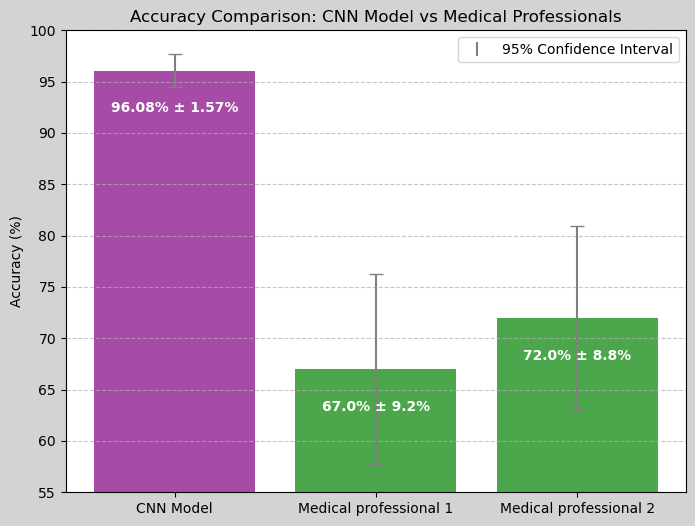

In [4]:
# Data
categories = ["CNN Model", "Medical professional 1", "Medical professional 2"]
accuracies = [96.08, 67.00, 72.00]
bounds = [1.57, 9.2, 8.8] # regnet i hånden

proportions = [0.96, 0.67, 0.70]  # Standard deviations
sample_sizes = [587, 100, 100]  # Sample sizes

# Beregn konfidensintervaller
crit_value = 1.96  # 95% konfidensniveau

# så regner vi konfidensintervallerne i en liste:
conf_intervals = []
for p, n in zip(proportions, sample_sizes):
    interval = crit_value * np.sqrt((p * (1 - p)) / n) * 100
    conf_intervals.append(interval)

# Baggrundsfarve:
plt.figure(figsize=(8, 6), facecolor='lightgray')

# Plot konfidensintervals mærkaterne:
bars = plt.bar(categories, accuracies, yerr=conf_intervals, capsize=5, ecolor='gray', color=['purple', 'green', 'green'], alpha=0.7) # alpha er gennemsigtigheden af farven

# Tilføj tekst på søjlerne
for bar, accuracy, bounds in zip(bars, accuracies, bounds):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 3, f"{accuracy}% ± {bounds}%", ha='center', va='top', fontsize=10, color="white", fontweight='bold')

# Tilføj en legend:
# denne kode har vi taget inspiration fra matplotlib dokumentationen
plt.errorbar([], [], yerr=5, ecolor='gray', linestyle='None', label='95% Confidence Interval')

# Plot opsætning
plt.legend(loc='upper right', fontsize=10)  # Legend i øverste højre hjørne
plt.title("Accuracy Comparison: CNN Model vs Medical Professionals")
plt.ylabel("Accuracy (%)")
plt.ylim(55, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Vis plot
plt.show()


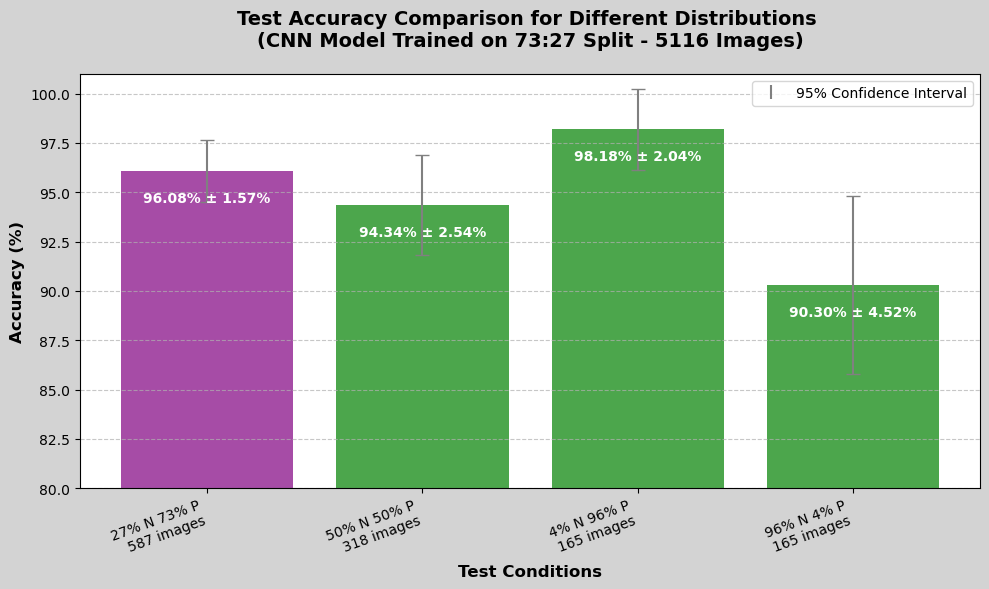

In [270]:
# Vi har brugt copilot til at lave dette plot:
# Data for plotting

# Data for 73:27 split trænet model
categories = [
    "27% N 73% P\n587 images",
    "50% N 50% P\n318 images",
    "4% N 96% P\n165 images",
    "96% N 4% P\n165 images"
]
test_accuracies = [96.08, 94.34, 98.18, 90.30]
title = "Test Accuracy Comparison for Different Distributions \n(CNN Model Trained on 73:27 Split - 5116 Images)" 

sample_sizes = [587, 318, 165, 165]

# Data for 50:50 split trænet model
# categories = [
#     "27% N 73% P\n587 images",
#     "50% N 50% P\n318 images",
#     "4% N 96% P\n165 images",
#     "96% N 4% P\n165 images",
    
# ]
# test_accuracies = [94.55, 95.60, 96.97, 95.76]
# sample_sizes = [587, 318, 165, 165]  # Sample sizes
# title = "Test Accuracy Comparison for Different Distributions \n(CNN Model Trained on 50:50 Split - 2532 Images)" # 50:50 split - 2532 images

proportions = [acc / 100.0 for acc in test_accuracies]

crit_value = 1.96  
conf_intervals = []
for p, n in zip(proportions, sample_sizes):
    se = np.sqrt(p * (1 - p) / n)
    interval_pct = crit_value * se * 100
    conf_intervals.append(interval_pct)

fig, ax = plt.subplots(figsize=(10, 6), facecolor='lightgray')

bars = ax.bar(
    categories, 
    test_accuracies, 
    yerr=conf_intervals, 
    capsize=5,            
    ecolor='gray',        
    color=['purple', 'green', 'green', 'green'], 
    alpha=0.7
)

max_acc = max(test_accuracies)            
max_ci  = max(conf_intervals)                        
ax.set_ylim(80, 101)                   

ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Test Conditions', fontsize=12, fontweight='bold')
ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=20, ha='right', fontsize=10)

for bar, accuracy, ci in zip(bars, test_accuracies, conf_intervals):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 1, 
        f"{accuracy:.2f}% ± {ci:.2f}%", 
        ha='center', 
        va='top', 
        fontsize=10, 
        color="white", 
        fontweight='bold'
    )

ax.errorbar([], [], yerr=5, ecolor='gray', linestyle='None', label='95% Confidence Interval')
ax.legend(loc='upper right', fontsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

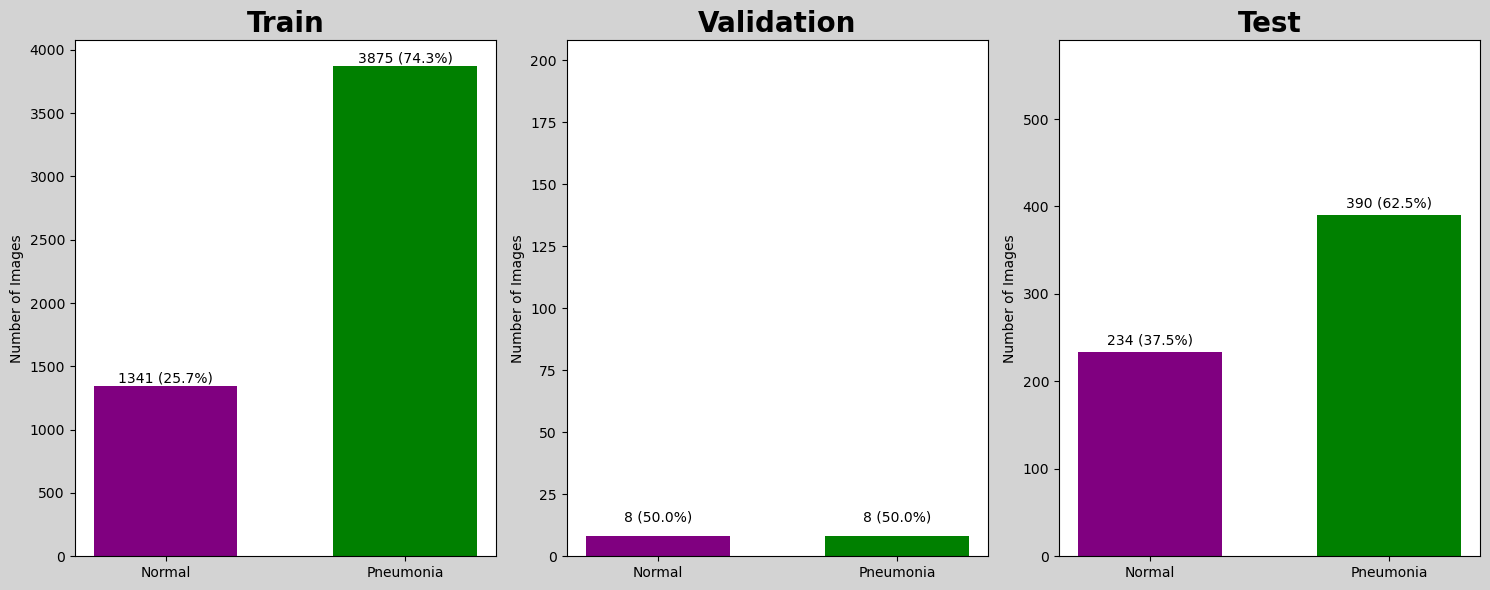

In [ ]:
# Her laver vi plot til at vise hvordan fordelingen af data er i de forskellige mappesæt som vi sorterede i starten af koden
# plot af fordeling før sortering:

splits = ['Train', 'Validation', 'Test']
categories = ['Normal', 'Pneumonia']

# vi aflæser antallet af billeder i hver mappe og undermappe:
data = {
    'Train': [1341, 3875],
    'Validation': [8, 8],
    'Test': [234, 390]
}

# Ud fra dette udregner vi procentdelen af normal og pneumonia billeder i hver mappe ved brug af ovenstående totale:
percentages = {
    'Train': [(round(1341 / (3875 + 1341) * 100,1)), (round(3875 / (3875 + 1341) * 100,1))],
    'Validation': [(round(8 / (8 + 8) * 100,1)), (round(8 / (8 + 8) * 100,1))],
    'Test': [(round(234 / (234 + 390) * 100,1)), (round(390 / (390 + 234) * 100,1))]
}

x = np.arange(len(categories))
width = 0.6 # bredden af søjlerne
fig, axes = plt.subplots(1, len(splits), figsize=(15, 6)) # 1 række, 3 kolonner

# Tegn søjlediagrammer for Train, Validation, og Test
for i in range(len(splits)):
    subplot = axes[i]  # Vælg det område, hvor dette split skal tegnes (fx Train)
    split = splits[i]  # Navnet på split (Train, Validation, Test)
    values = data[split]  # Antal billeder for Normal og Pneumonia
    percents = percentages[split]  # Procentdel for Normal og Pneumonia

    # Tegn søjlerne i dette subplot
    bars = subplot.bar(x, values, width, color=['purple', 'green'])  # Tegn Normal og Pneumonia søjler

    # Skriver tekst ovenover hver søjle
    for j in range(len(values)):
        søjle = bars[j]  # Hent den enkelte søjle
        antal = values[j]  # Antallet af billeder for denne søjle
        procent = percents[j]  # Procentdelen for denne søjle
        # Tilføj tekst over søjlen
        subplot.text(søjle.get_x() + søjle.get_width() / 2, søjle.get_height() + 5, f"{antal} ({procent:.1f}%)", ha='center', va='bottom')

    # Tilføj titel og labels for dette subplot
    subplot.set_title(f"{split}", fontsize=20, fontweight='bold') # Titel for dette plot (fx Train)
    subplot.set_xticks(x)  # Sæt x-aksens positioner
    subplot.set_xticklabels(categories)  # Navngiv x-aksens kategorier (Normal, Pneumonia)
    subplot.set_ylim(0, max(values) + 200)  # Sæt y-aksens maksimum
    subplot.set_ylabel('Number of Images')  # Y-aksens label

    # Alt med subplot. repræsenterer en enkelt søjle i søjlediagrammet

fig.patch.set_facecolor('lightgray')  # Baggrundsfarve figuren
plt.tight_layout()
plt.show()


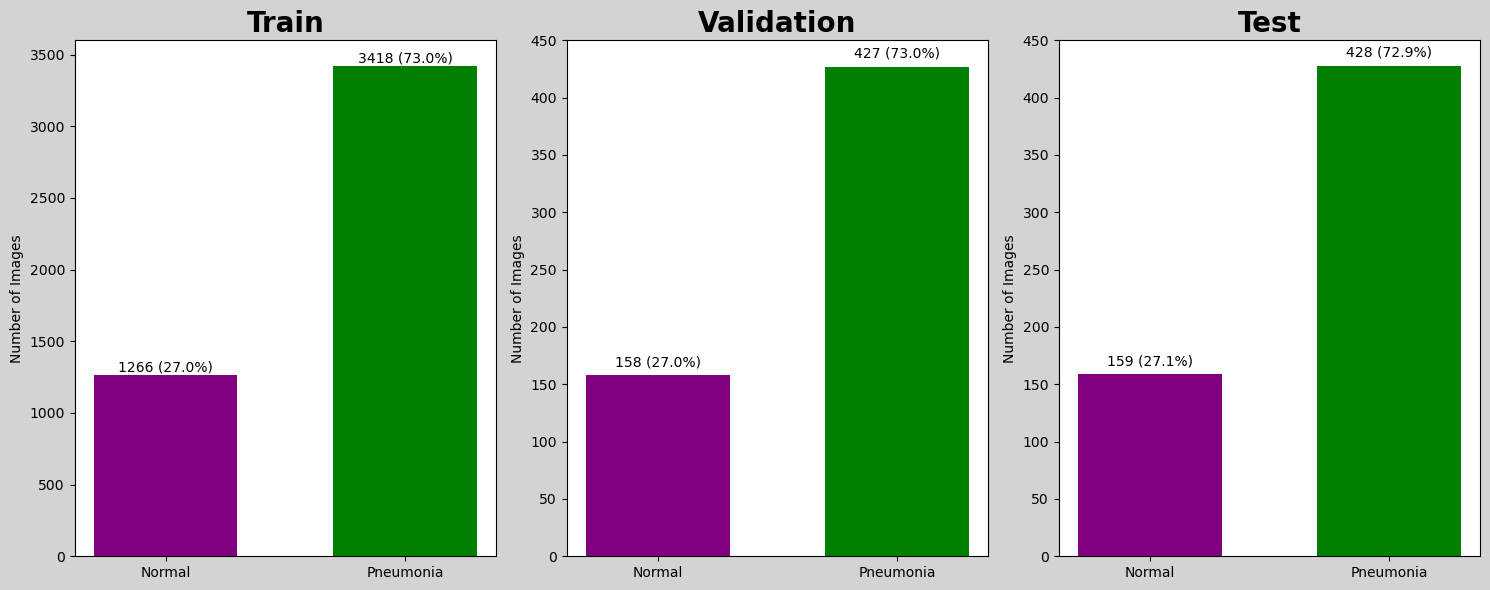

In [109]:
# plot af fordeling før sortering:
# Dataen:
splits = ['Train', 'Validation', 'Test']
categories = ['Normal', 'Pneumonia']
data = {
    'Train': [1266, 3418],
    'Validation': [158, 427],
    'Test': [159, 428]
}

# Ud fra dette udregner vi procentdelen af normal og pneumonia billeder i hver mappe ved brug af ovenstående totale:
percentages = {
    'Train': [(round(1266 / (1266 + 3418) * 100, 1)), (round(3418 / (1266 + 3418) * 100, 1))],
    'Validation': [(round(158 / (158 + 427) * 100, 1)), (round(427 / (158 + 427) * 100, 1))],
    'Test': [(round(159 / (159 + 428) * 100, 1)), (round(428 / (159 + 428) * 100, 1))]
}

# Denne her ide har vi fået fra chat-gpt og den gør at vi kan benytte manuelle akse-grænser i de forskellige subplots:
manual_ylim = {
    'Train': 3600,  
    'Validation': 450,  
    'Test': 450 
}

x = np.arange(len(categories))
width = 0.6 # bredden af søjlerne
fig, axes = plt.subplots(1, len(splits), figsize=(15, 6)) # 1 række, 3 kolonner

# Tegn søjlediagrammer for Train, Validation, og Test
for i in range(len(splits)):
    subplot = axes[i]  # Vælg det område, hvor dette split skal tegnes (fx Train)
    split = splits[i]  # Navnet på split (Train, Validation, Test)
    values = data[split]  # Antal billeder for Normal og Pneumonia
    percents = percentages[split]  # Procentdel for Normal og Pneumonia

    # Tegn søjlerne i dette subplot
    bars = subplot.bar(x, values, width, color=['purple','green'])  # Tegn Normal og Pneumonia søjler

    # Skriver tekst ovenover hver søjle
    for j in range(len(values)):
        søjle = bars[j]  # Hent den enkelte søjle
        antal = values[j]  # Antallet af billeder for denne søjle
        procent = percents[j]  # Procentdelen for denne søjle
        # Tilføj tekst over søjlen
        subplot.text(søjle.get_x() + søjle.get_width() / 2, søjle.get_height() + 5, f"{antal} ({procent:.1f}%)", ha='center', va='bottom')

    # Tilføj titel og labels for dette subplot
    subplot.set_title(f"{split}", fontsize=20, fontweight='bold') 
    subplot.set_xticks(x)  # Sætter x-aksens positioner
    subplot.set_xticklabels(categories)  # Navngiver x-aksens kategorier (Normal, Pneumonia)
    subplot.set_ylim(0, manual_ylim[split])  # Her bruger vi de manuelle grænser
    subplot.set_ylabel('Number of Images')  # Y-aksens label

    # Alt med subplot. repræsenterer en enkelt søjle i søjlediagrammet

fig.patch.set_facecolor('lightgray')  # Baggrundsfarve for figuren
plt.tight_layout()
plt.show()


In [205]:
# Det her er til vores visualisering af vores data:
# vi bruger samme lister som sidst:

FP = [] # gætter på pnemonia men det er normal
FN = [] # gætter på normal men det er pnemonia

for i in range(len(actual_values_list)):
    if actual_values_list[i] == 0 and predicted_values_list[i] == 1:
        FP.append(i)
    elif actual_values_list[i] == 1 and predicted_values_list[i] == 0:
        FN.append(i)

# nu har vi to lister med FP og FN hvor vi så kan finde de tilhørende billeder i vores test_dataset.